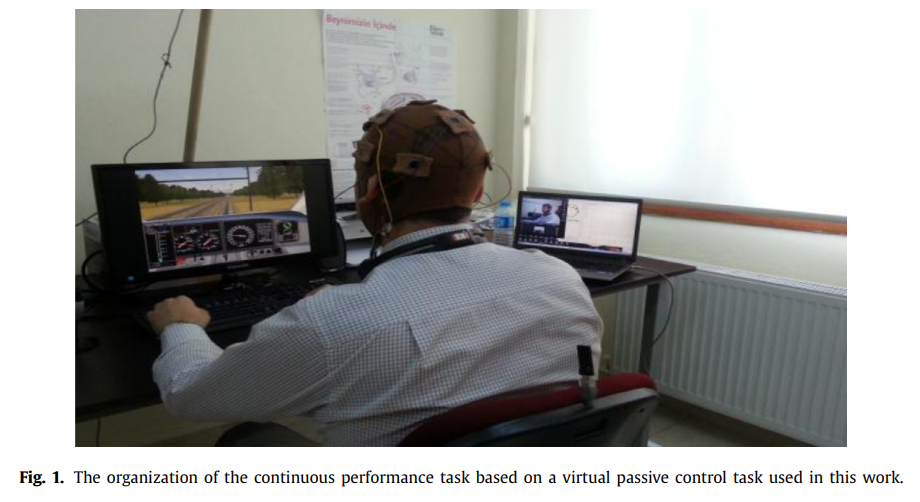

# <center> Задача: 
### Классификация
    Пример: Определить, находится ли человек в состоянии концентрации или расслабления на основе данных ЭЭГ.
* Тип задачи: Классификация временных рядов.
* Подход: Мы используем метки (например, "активное внимание" или "расслабление") и обучаем модель различать эти состояния.
* Алгоритмы: Логистическая регрессия, SVM, нейронные сети (например, RNN, LSTM).

### Проблема, решаемая моделью:

* Прогнозирование классов (активен или неактивен).
    Пример применения: Детектирование эпилептических приступов, выявление состояний внимания.

---
---

## Датасет

Это оригинальный набор данных, включающий в общей сложности 25 часовых записей ЭЭГ, собранных у 5 участников, выполняющих контрольную задачу низкой интенсивности. Задача заключалась в управлении поездом, смоделированным на компьютере, с помощью программы «Microsoft Train Simulator». В каждом эксперименте участники управляли поездом в течение 35–55 минут по преимущественно безликому маршруту в вышеупомянутой программе компьютерного моделирования.

Условности данных: (according to the comments on the Data source).

The states seem to be defined arbitrarily as 10 min adjacent periods.

* 1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
* 2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
* Remaining data(t=20 min to onwards) is for "Drowsed" state

1. Чтение и предобработка данных
* Извлекаем только нужные каналы:
    ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']
* Удаляем неиспользуемые или референс-каналы (например, T7, Т8).

2. Список каналов для анализа (согласно описанию):
* Все каналы: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
            'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
* Исключенные каналы: остальные (не использовались как активные каналы)

Цитаты от автора датасета: 

"We modified the headset to allow the electrodes to be placed over frontal and parietal lobes of the scalp (Figure 2), whereas the original Epoc headset only allowed electrode coverage over frontal and occipital areas within a rigid plastic spider-web cap format. Thus, the positions of the electrodes used in this work were F3-Fz-F4-C3-Cz-C4-T3-T4-T5-T6-Pz in the standard 10-20 system. In the EEG device, 4 leads (here identified by the locations T3, T4, T5, and T6) were used to supply current and establish the EEG reference and could not be used for data collection. The acquired data from the 7 leads were identified by F3, F4, Fz, C3, C4, Cz, and Pz. There is data on non-used channels because the channels still connect to the emotiv just dont put on the head."

"Correct one is :
2,3,5,6,7,8,9,10,14==>F7,F3,T7,P7,O1,O2,P8,T8,AF4

5 and 10 were not used because they are reference channels"

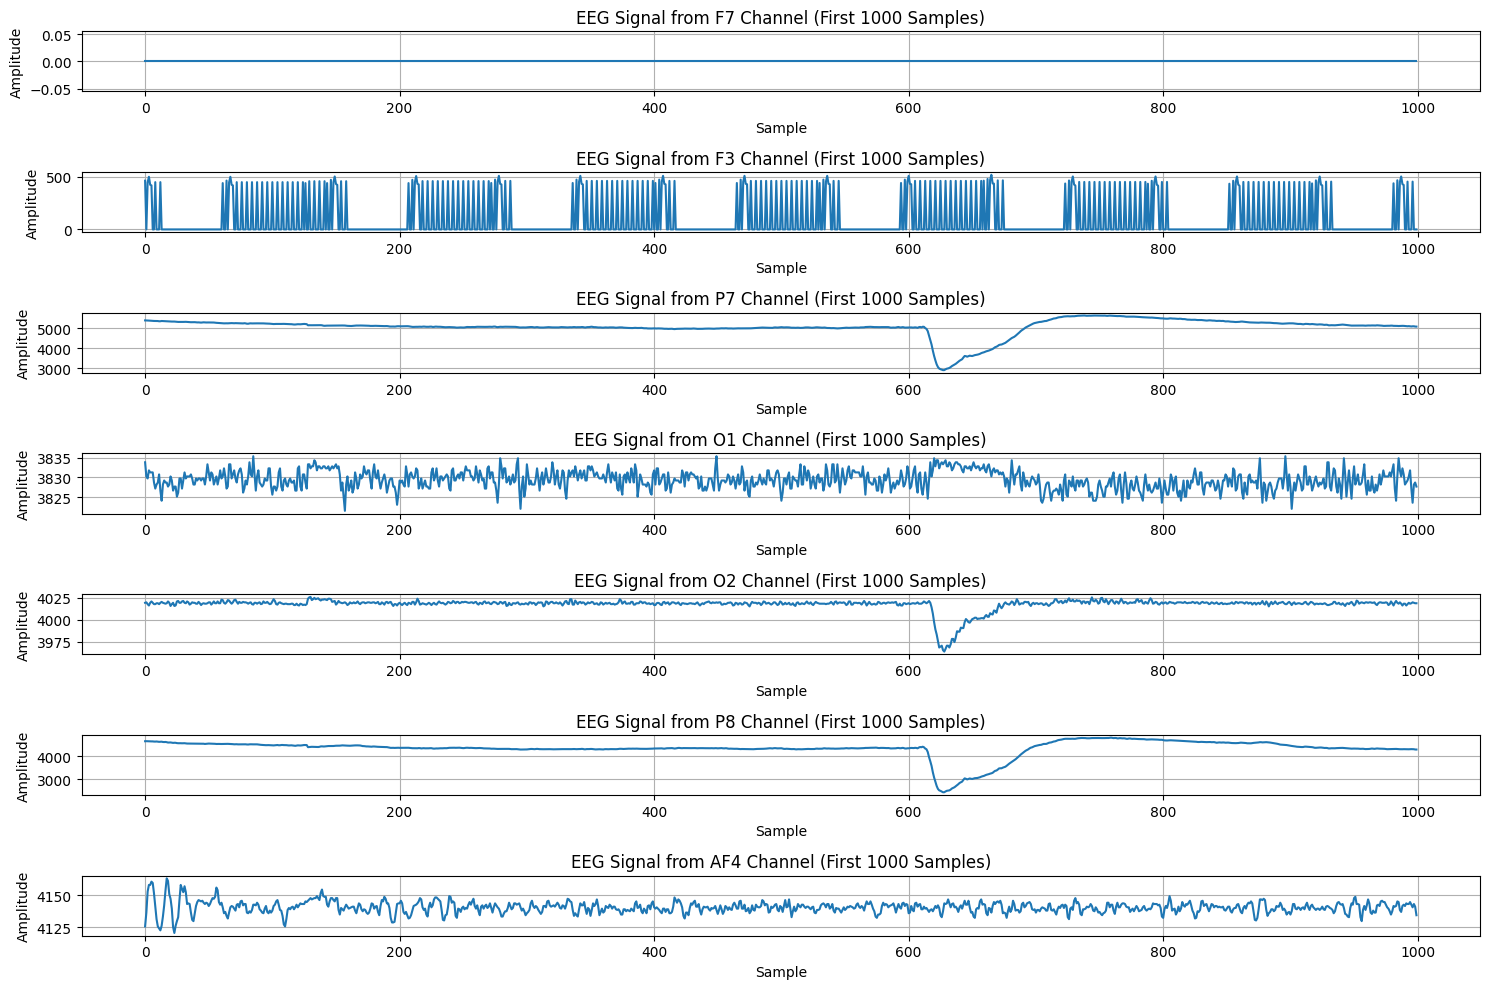

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузка данных из .mat файла
data = scipy.io.loadmat("data/EEG Data/eeg_record1.mat")  # Укажите путь к файлу
eeg_data = data['o']['data'][0, 0]  # Извлечение данных

# 2. Определение каналов и индексов полезных каналов
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
            'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
useful_channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

# Поиск индексов полезных каналов
use_channel_inds = [channels.index(c) for c in useful_channels]

# 3. Извлечение данных только для полезных каналов
filtered_data = eeg_data[:, use_channel_inds]

# 4. Визуализация полезных каналов
plt.figure(figsize=(15, 10))
for i, channel_name in enumerate(useful_channels):
    plt.subplot(len(useful_channels), 1, i + 1)
    plt.plot(filtered_data[:1000, i])  # Первые 1000 сэмплов
    plt.title(f"EEG Signal from {channel_name} Channel (First 1000 Samples)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()


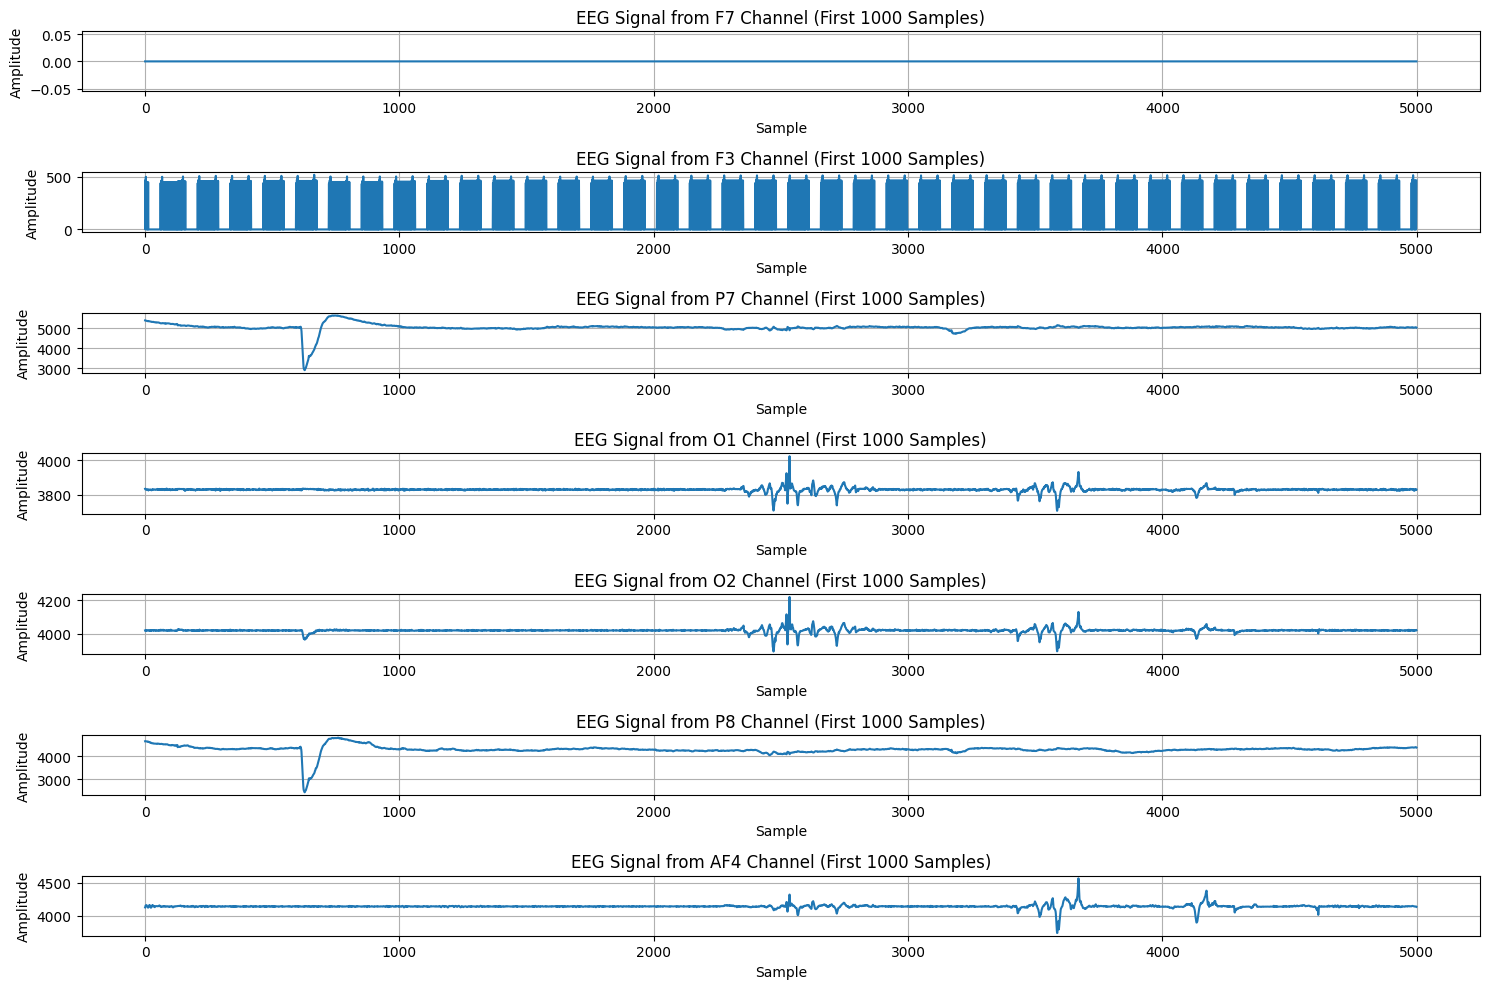

In [8]:
plt.figure(figsize=(15, 10))
for i, channel_name in enumerate(useful_channels):
    plt.subplot(len(useful_channels), 1, i + 1)
    plt.plot(filtered_data[:5000, i])  # Первые 1000 сэмплов для текущего канала
    plt.title(f"EEG Signal from {channel_name} Channel (First 1000 Samples)")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Загрузка данных
data = scipy.io.loadmat("data/EEG Data/eeg_record1.mat")  # Укажите путь к файлу
eeg_data = data['o']['data'][0, 0]  # Извлечение данных

# 2. Определение каналов и полезных каналов
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
            'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
useful_channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']
use_channel_inds = [channels.index(c) for c in useful_channels]

# 3. Извлечение данных для полезных каналов
filtered_data = eeg_data[:, use_channel_inds]

# 4. Частота дискретизации
FS = 128  # Гц

# 5. Разметка данных по состояниям
states = {
    'focused': filtered_data[:FS * 10 * 60, :],
    'unfocused': filtered_data[FS * 10 * 60:FS * 20 * 60, :],
    'drowsy': filtered_data[FS * 20 * 60:, :]
}

# 6. Извлечение признаков: среднее значение и стандартное отклонение по временным рядам
features = []
labels = []
for state, data in states.items():
    for row in data:
        mean_val = np.mean(row)
        std_val = np.std(row)
        features.append([mean_val, std_val])
        labels.append(state)

# 7. Разделение данных на обучающую и тестовую выборки
X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Обучение KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 9. Предсказание и оценка точности KNN
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")

# 10. Обучение SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# 11. Предсказание и оценка точности SVM
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")


KNN Accuracy: 0.54


In [3]:
data['o']['id'][0, 0]

array(['201410092013.D091BB44'], dtype='<U21')

In [5]:
import scipy.io
import numpy as np

# Список файлов
file_paths = ["data/EEG Data/eeg_record1.mat", "data/EEG Data/eeg_record2.mat", "data/EEG Data/eeg_record3.mat", "data/EEG Data/eeg_record4.mat", "data/EEG Data/eeg_record5.mat", "data/EEG Data/eeg_record6.mat", "data/EEG Data/eeg_record7.mat", "data/EEG Data/eeg_record8.mat",
              "data/EEG Data/eeg_record9.mat", "data/EEG Data/eeg_record10.mat", "data/EEG Data/eeg_record11.mat", "data/EEG Data/eeg_record12.mat", "data/EEG Data/eeg_record13.mat", "data/EEG Data/eeg_record14.mat", "data/EEG Data/eeg_record15.mat", "data/EEG Data/eeg_record16.mat",
                "data/EEG Data/eeg_record17.mat", "data/EEG Data/eeg_record18.mat", "data/EEG Data/eeg_record19.mat", "data/EEG Data/eeg_record20.mat", "data/EEG Data/eeg_record21.mat" ,"data/EEG Data/eeg_record22.mat","data/EEG Data/eeg_record23.mat","data/EEG Data/eeg_record24.mat",
                "data/EEG Data/eeg_record25.mat", "data/EEG Data/eeg_record26.mat", "data/EEG Data/eeg_record27.mat", "data/EEG Data/eeg_record28.mat", "data/EEG Data/eeg_record29.mat", "data/EEG Data/eeg_record30.mat", "data/EEG Data/eeg_record31.mat", "data/EEG Data/eeg_record32.mat",
                 "data/EEG Data/eeg_record33.mat", "data/EEG Data/eeg_record34.mat"]  # Укажите пути к вашим 34 файлам

FS = 128  # Частота дискретизации
participant_data = {}  # Словарь для хранения данных по участникам

for file_path in file_paths:
    data = scipy.io.loadmat(file_path)
    eeg_data = data['o']['data'][0, 0]  # Извлечение данных

    # Извлечение ID участника
    participant_id = data['o']['id'][0, 0][0]  # Получение строки из массива
    if participant_id not in participant_data:
        participant_data[participant_id] = []

    # Определение каналов и полезных каналов
    channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    useful_channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']
    use_channel_inds = [channels.index(c) for c in useful_channels]

    # Извлечение данных для полезных каналов
    filtered_data = eeg_data[:, use_channel_inds]

    # Разметка данных по состояниям
    states = {
        'focused': filtered_data[:FS * 10 * 60, :],  # 0-10 минут
        'unfocused': filtered_data[FS * 10 * 60:FS * 20 * 60, :],  # 10-20 минут
        'drowsy': filtered_data[FS * 20 * 60:, :]  # 20 минут и далее
    }

    # Добавление данных участника
    participant_data[participant_id].append(states)

# Пример: Извлечение признаков для каждого участника
all_features = []
all_labels = []

for participant_id, states_list in participant_data.items():
    for states in states_list:
        for state, data in states.items():
            for row in data:
                mean_val = np.mean(row)
                std_val = np.std(row)
                all_features.append([mean_val, std_val])
                all_labels.append(state)

# Преобразование в массивы
X = np.array(all_features)
y = np.array(all_labels)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Шаг 1: Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Шаг 2: Создание и обучение модели KNN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Можно настроить количество соседей
knn_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
knn_predictions = knn_model.predict(X_test)

# Оценка точности KNN
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy:.2f}")


KNN Accuracy: 0.55
